In [31]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco

In [41]:
tickers = ['MSFT', 'NVDA', 'AAPL']

# Download historical data
data = yf.download(tickers, start='2010-01-01', end='2024-12-31', group_by='ticker')

# Extract and process each stock
def process_stock(ticker):
    df = data[ticker].copy()
    df['Return'] = df['Close'].pct_change()
    df['Ticker'] = ticker
    return df

# Process all tickers and concatenate
tech_df = pd.concat([process_stock(t) for t in tickers])

# Reset index for easier use
tech_df.reset_index(inplace=True)

# Preview merged data
print(tech_df.head())

/var/folders/g_/z855dh_n3rsf7yvh00mp3jkc0000gn/T/ipykernel_27401/1936158343.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2010-01-01', end='2024-12-31', group_by='ticker')
[*********************100%***********************]  3 of 3 completed

Price       Date       Open       High        Low      Close    Volume  \
0     2010-01-04  22.963954  23.323938  22.941455  23.211443  38409100   
1     2010-01-05  23.136444  23.323935  22.978950  23.218939  49749600   
2     2010-01-06  23.158938  23.308932  22.888951  23.076443  58182400   
3     2010-01-07  22.971449  23.023948  22.641465  22.836456  50559700   
4     2010-01-08  22.708965  23.158944  22.678966  22.993952  51197400   

Price    Return Ticker  
0           NaN   MSFT  
1      0.000323   MSFT  
2     -0.006137   MSFT  
3     -0.010400   MSFT  
4      0.006897   MSFT  


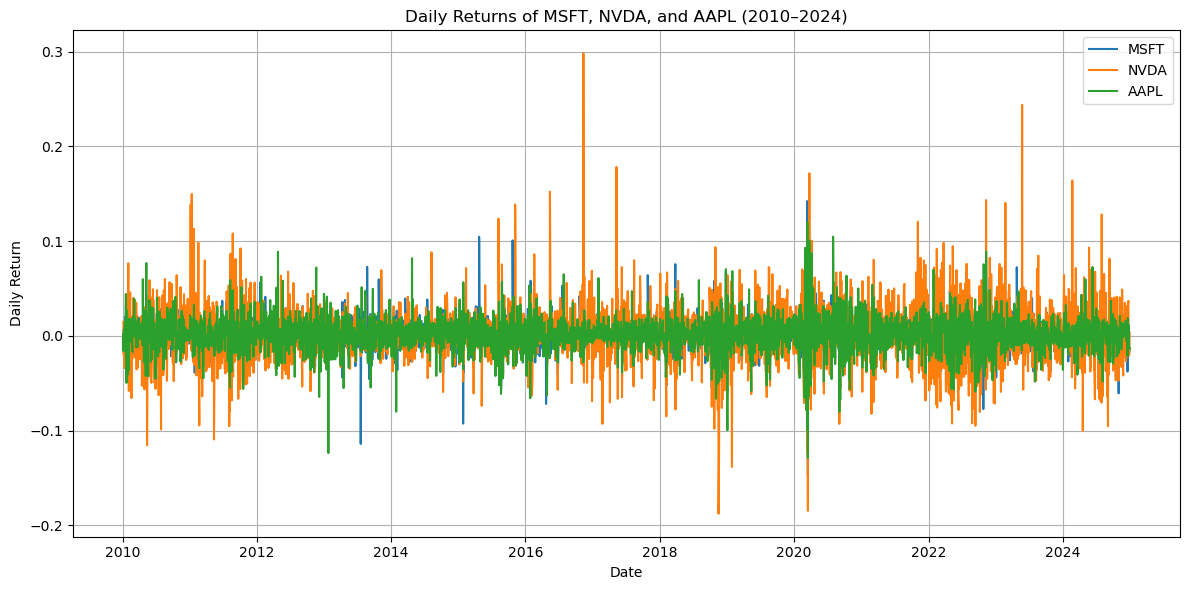

In [42]:
#plotting returns over time for tech stocks

tech_df['Date'] = pd.to_datetime(tech_df['Date'])

# Plot daily returns for each stock
plt.figure(figsize=(12, 6))

for ticker in tech_df['Ticker'].unique():
    ticker_data = tech_df[tech_df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Return'], label=ticker)

plt.title('Daily Returns of MSFT, NVDA, and AAPL (2010–2024)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- MSFT ---
ADF p-value: 0.0000 -> Stationary


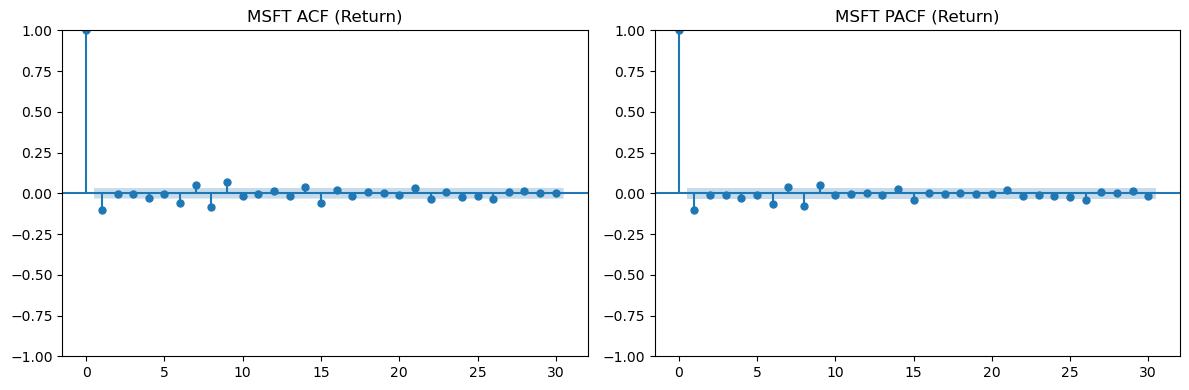


--- NVDA ---
ADF p-value: 0.0000 -> Stationary


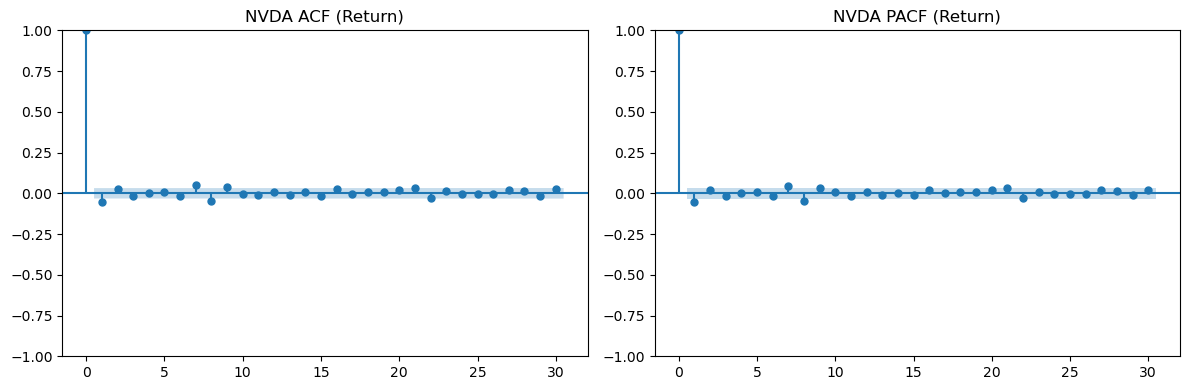


--- AAPL ---
ADF p-value: 0.0000 -> Stationary


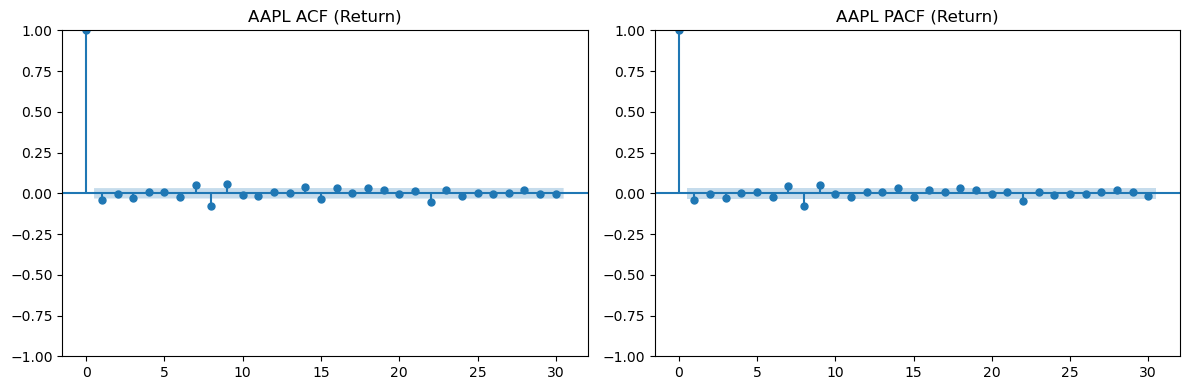

In [43]:
# Plot ACF and PACF for each stock's returns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for ticker in tech_df['Ticker'].unique():
    print(f"\n--- {ticker} ---")
    ticker_data = tech_df[tech_df['Ticker'] == ticker]
    returns = ticker_data['Return'].dropna()

    result = adfuller(returns)
    print(f"ADF p-value: {result[1]:.4f} -> {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(returns, ax=axes[0], lags=30)
    plot_pacf(returns, ax=axes[1], lags=30)
    axes[0].set_title(f'{ticker} ACF (Return)')
    axes[1].set_title(f'{ticker} PACF (Return)')
    plt.tight_layout()
    plt.show()

From the ACF and PACF plot, we can't really determine the order and as there are no significant spikes after lag 0, so we consider using AIC to determine the best order. 

In [44]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

for ticker in tech_df['Ticker'].unique():
    print(f"\n{ticker} ARMA model selection (based on AIC):")
    ticker_data = tech_df[tech_df['Ticker'] == ticker]
    returns = ticker_data['Return'].dropna()

    best_aic = float('inf')
    best_order = None

    for p in range(0, 5):
        for q in range(0, 5):
            try:
                model = ARIMA(returns, order=(p, 0, q))  # ARMA = ARIMA with d=0
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, q)
            except:
                continue

    print(f"Best ARMA order: {best_order} with AIC: {best_aic:.2f}")


MSFT ARMA model selection (based on AIC):
Best ARMA order: (1, 4) with AIC: -20488.03

NVDA ARMA model selection (based on AIC):
Best ARMA order: (3, 4) with AIC: -16119.05

AAPL ARMA model selection (based on AIC):
Best ARMA order: (4, 4) with AIC: -19815.88


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def forecast_last_30days_ARMA_eval(df, ticker, order):
    print(f"\nForecasting last 30 days for {ticker} using ARMA{order}...")

    # Filter ticker-specific data
    data = df[df['Ticker'] == ticker].dropna(subset=['Return']).reset_index(drop=True)
    returns = data['Return'].values
    dates = data['Date'].values

    # Train-test split (last 30 days as test)
    train, test = returns[:-30], returns[-30:]
    test_dates = dates[-30:]

    # Fit ARMA model
    model = ARIMA(train, order=(order[0], 0, order[1]))
    model_fit = model.fit()

    # Forecast next 30 steps
    forecast = model_fit.forecast(steps=30)

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    # Print metrics
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

    # Plot actual vs predicted returns
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, test, label='Actual Returns', color='blue', marker='o')
    plt.plot(test_dates, forecast, label='Predicted Returns', color='red', linestyle='--', marker='x')
    plt.title(f'{ticker}: Actual vs Forecasted Returns (Last 30 Days)\nMAE={mae:.5f}, RMSE={rmse:.5f}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae, rmse


Forecasting last 30 days for MSFT using ARMA(1, 4)...
MAE:  0.008952
RMSE: 0.012410


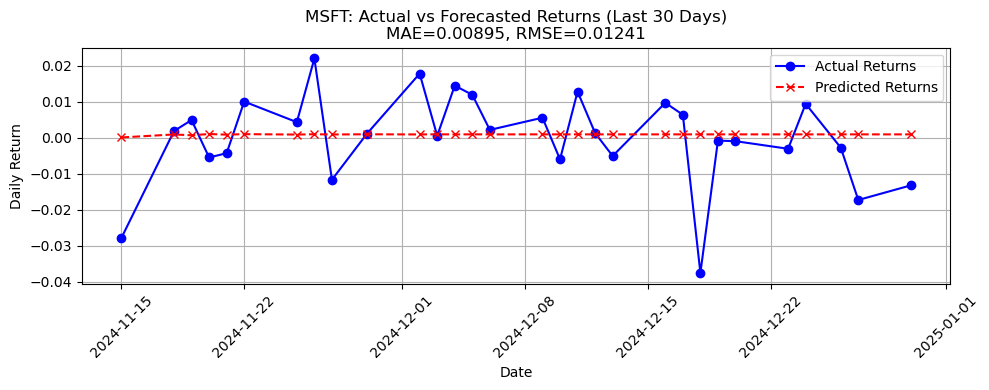


Forecasting last 30 days for NVDA using ARMA(3, 4)...
MAE:  0.018857
RMSE: 0.022798


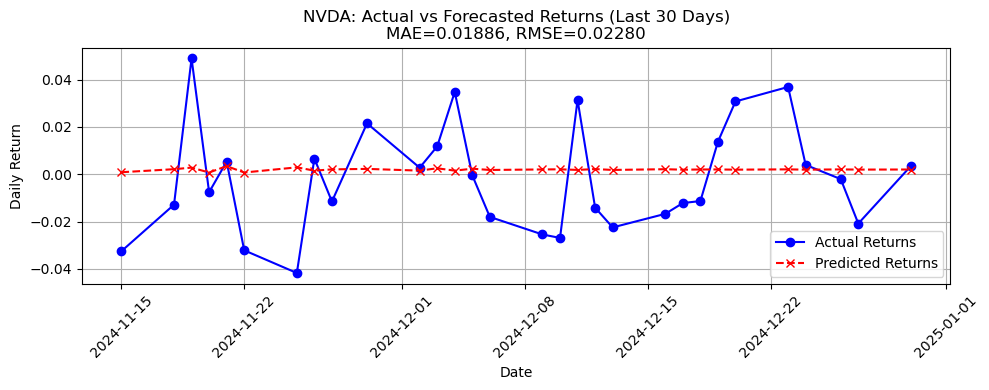


Forecasting last 30 days for AAPL using ARMA(4, 4)...
MAE:  0.007726
RMSE: 0.009626


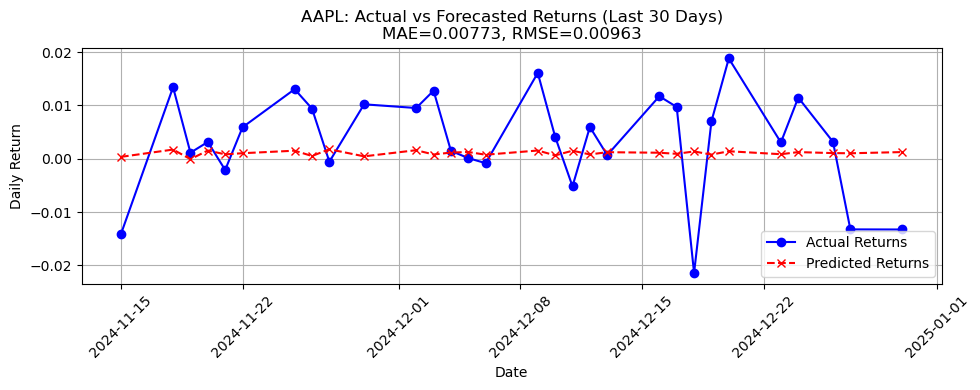

In [50]:
results = {}

results['MSFT'] = forecast_last_30days_ARMA_eval(tech_df, 'MSFT', (1, 4))
results['NVDA'] = forecast_last_30days_ARMA_eval(tech_df, 'NVDA', (3, 4))
results['AAPL'] = forecast_last_30days_ARMA_eval(tech_df, 'AAPL', (4, 4))

PHARMA Stocks

In [53]:
tickers = ['LLY', 'JNJ', 'NVO']

# Download historical data
data = yf.download(tickers, start='2010-01-01', end='2024-12-31', group_by='ticker')

# Extract and process each stock
def process_stock(ticker):
    df = data[ticker].copy()
    df['Return'] = df['Close'].pct_change()
    df['Ticker'] = ticker
    return df

# Process all tickers and concatenate
pharma_df = pd.concat([process_stock(t) for t in tickers])

# Reset index for easier use
pharma_df.reset_index(inplace=True)

# Preview merged data
print(pharma_df.head())

[*********************100%***********************]  3 of 3 completed


Price       Date       Open       High        Low      Close   Volume  \
0     2010-01-04  23.541286  23.923000  23.541286  23.574192  6067100   
1     2010-01-05  23.626848  23.633429  22.988462  23.159575  7517100   
2     2010-01-06  23.192486  23.383341  23.192486  23.330692  7661600   
3     2010-01-07  23.357022  23.403091  23.133258  23.212233  5997100   
4     2010-01-08  23.218810  23.218810  22.929234  23.034534  5624400   

Price    Return Ticker  
0           NaN    LLY  
1     -0.017588    LLY  
2      0.007389    LLY  
3     -0.005077    LLY  
4     -0.007655    LLY  


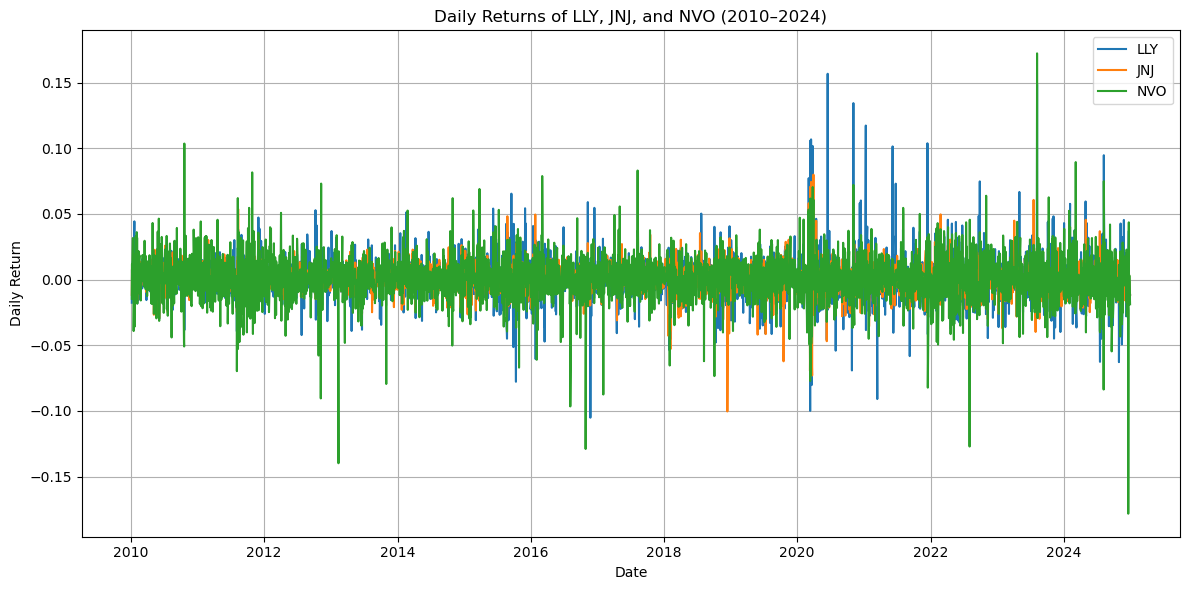

In [54]:
#plotting returns over time for tech stocks

pharma_df['Date'] = pd.to_datetime(pharma_df['Date'])

# Plot daily returns for each stock
plt.figure(figsize=(12, 6))

for ticker in pharma_df['Ticker'].unique():
    ticker_data = pharma_df[pharma_df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Return'], label=ticker)

plt.title('Daily Returns of LLY, JNJ, and NVO (2010–2024)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- LLY ---
ADF p-value: 0.0000 -> Stationary


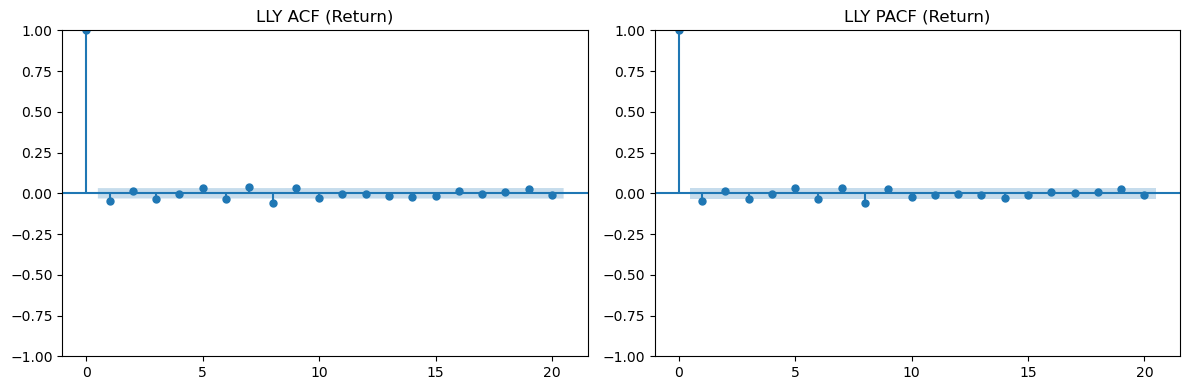


--- JNJ ---
ADF p-value: 0.0000 -> Stationary


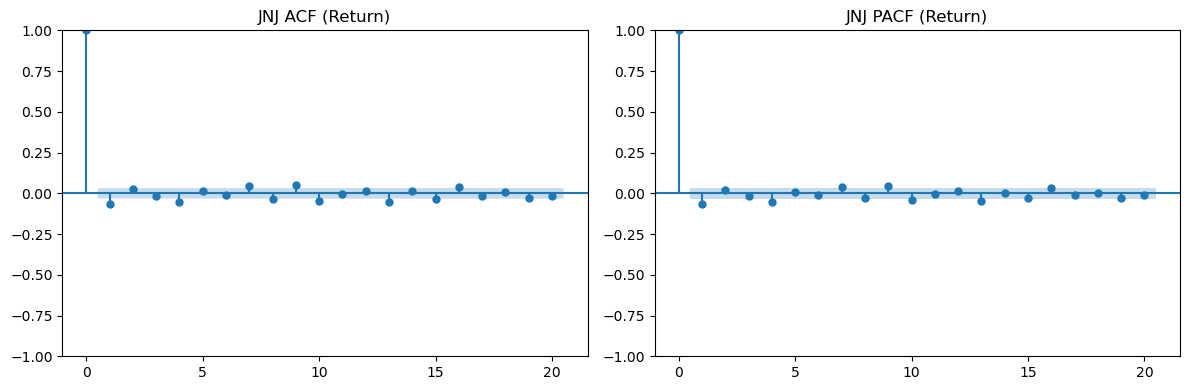


--- NVO ---
ADF p-value: 0.0000 -> Stationary


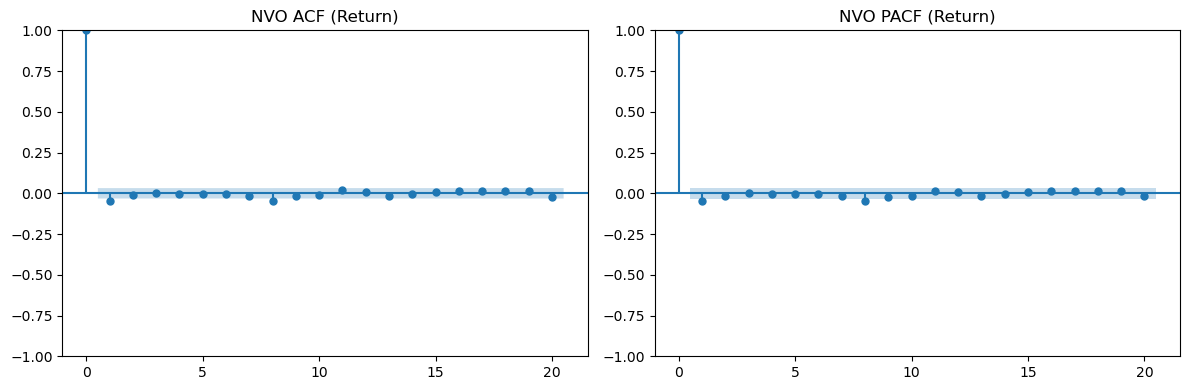

In [57]:
for ticker in pharma_df['Ticker'].unique():
    print(f"\n--- {ticker} ---")
    ticker_data = pharma_df[pharma_df['Ticker'] == ticker]
    returns = ticker_data['Return'].dropna()

    result = adfuller(returns)
    print(f"ADF p-value: {result[1]:.4f} -> {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(returns, ax=axes[0], lags=20)
    plot_pacf(returns, ax=axes[1], lags=20)
    axes[0].set_title(f'{ticker} ACF (Return)')
    axes[1].set_title(f'{ticker} PACF (Return)')
    plt.tight_layout()
    plt.show()

In [58]:
for ticker in pharma_df['Ticker'].unique():
    print(f"\n{ticker} ARMA model selection (based on AIC):")
    ticker_data = pharma_df[pharma_df['Ticker'] == ticker]
    returns = ticker_data['Return'].dropna()

    best_aic = float('inf')
    best_order = None

    for p in range(0, 5):
        for q in range(0, 5):
            try:
                model = ARIMA(returns, order=(p, 0, q))  # ARMA = ARIMA with d=0
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, q)
            except:
                continue

    print(f"Best ARMA order: {best_order} with AIC: {best_aic:.2f}")


LLY ARMA model selection (based on AIC):
Best ARMA order: (1, 4) with AIC: -20660.70

JNJ ARMA model selection (based on AIC):
Best ARMA order: (1, 4) with AIC: -23672.68

NVO ARMA model selection (based on AIC):
Best ARMA order: (0, 1) with AIC: -19951.20


In [64]:
def forecast_last_30days_ARMA(df, ticker, order):
    print(f"\nForecasting last 30 days for {ticker} using ARMA{order}...")

    # Filter ticker-specific data
    data = df[df['Ticker'] == ticker].dropna(subset=['Return']).reset_index(drop=True)
    returns = data['Return'].values
    dates = data['Date'].values

    # Train-test split (last 30 days as test)
    train, test = returns[:-30], returns[-30:]
    test_dates = dates[-30:]

    # Fit ARMA model
    model = ARIMA(train, order=(order[0], 0, order[1]))
    model_fit = model.fit()

    # Forecast next 30 steps
    forecast = model_fit.forecast(steps=30)

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    # Print metrics
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

    # Plot actual vs predicted returns
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, test, label='Actual Returns', color='blue', marker='o')
    plt.plot(test_dates, forecast, label='Predicted Returns', color='red', linestyle='--', marker='x')
    plt.title(f'{ticker}: Actual vs Forecasted Returns (Last 30 Days)\nMAE={mae:.5f}, RMSE={rmse:.5f}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae, rmse


Forecasting last 30 days for LLY using ARMA(1, 4)...
MAE:  0.014061
RMSE: 0.019129


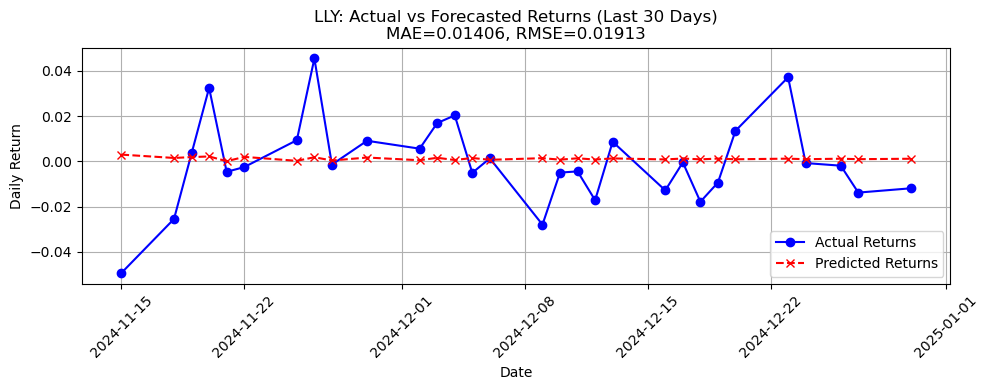


Forecasting last 30 days for JNJ using ARMA(1, 4)...
MAE:  0.007282
RMSE: 0.009283


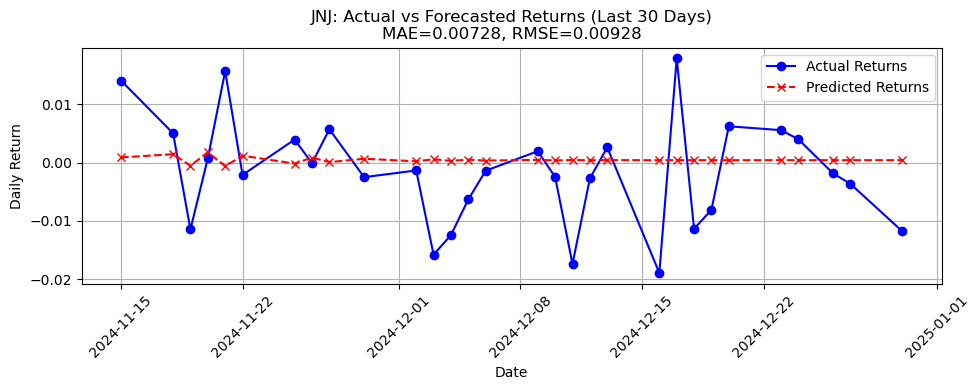


Forecasting last 30 days for NVO using ARMA(0, 1)...
MAE:  0.021043
RMSE: 0.037714


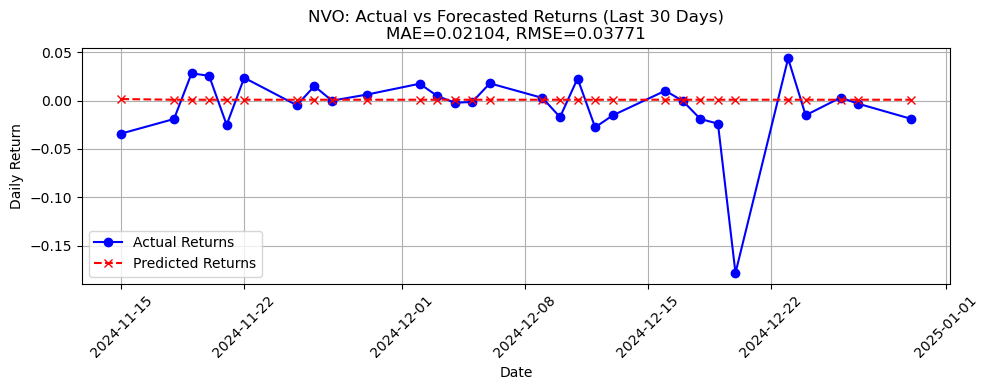

In [65]:
results = {}

results['LLY'] = forecast_last_30days_ARMA(pharma_df, 'LLY', (1, 4))
results['JNJ'] = forecast_last_30days_ARMA(pharma_df, 'JNJ', (1, 4))
results['NVO'] = forecast_last_30days_ARMA(pharma_df, 'NVO', (0, 1))

Financial stocks

In [66]:
tickers = ['JPM', 'V', 'MA']

# Download historical data
data = yf.download(tickers, start='2010-01-01', end='2024-12-31', group_by='ticker')

# Extract and process each stock
def process_stock(ticker):
    df = data[ticker].copy()
    df['Return'] = df['Close'].pct_change()
    df['Ticker'] = ticker
    return df

# Process all tickers and concatenate
financial_df = pd.concat([process_stock(t) for t in tickers])

# Reset index for easier use
financial_df.reset_index(inplace=True)

# Preview merged data
print(financial_df.head())

[*********************100%***********************]  3 of 3 completed

Price       Date       Open       High        Low      Close    Volume  \
0     2010-01-04  28.116010  28.923361  28.035273  28.829168  35460500   
1     2010-01-05  28.788794  29.495226  28.782065  29.387579  41208300   
2     2010-01-06  29.232859  29.663447  29.138669  29.549070  27729000   
3     2010-01-07  29.461621  30.356435  29.340518  30.134415  44864700   
4     2010-01-08  29.851828  30.073850  29.656719  30.060394  33110100   

Price    Return Ticker  
0           NaN    JPM  
1      0.019370    JPM  
2      0.005495    JPM  
3      0.019809    JPM  
4     -0.002456    JPM  


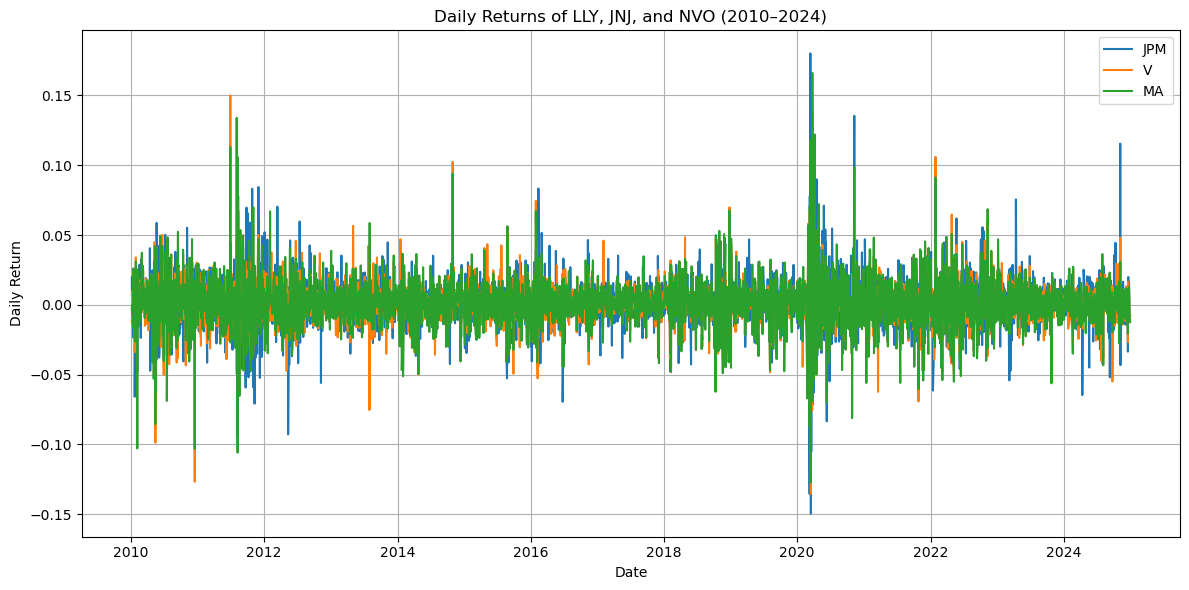

In [67]:
#plotting returns over time for financial stocks

financial_df['Date'] = pd.to_datetime(pharma_df['Date'])

# Plot daily returns for each stock
plt.figure(figsize=(12, 6))

for ticker in financial_df['Ticker'].unique():
    ticker_data = financial_df[financial_df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Return'], label=ticker)

plt.title('Daily Returns of LLY, JNJ, and NVO (2010–2024)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- JPM ---
ADF p-value: 0.0000 -> Stationary


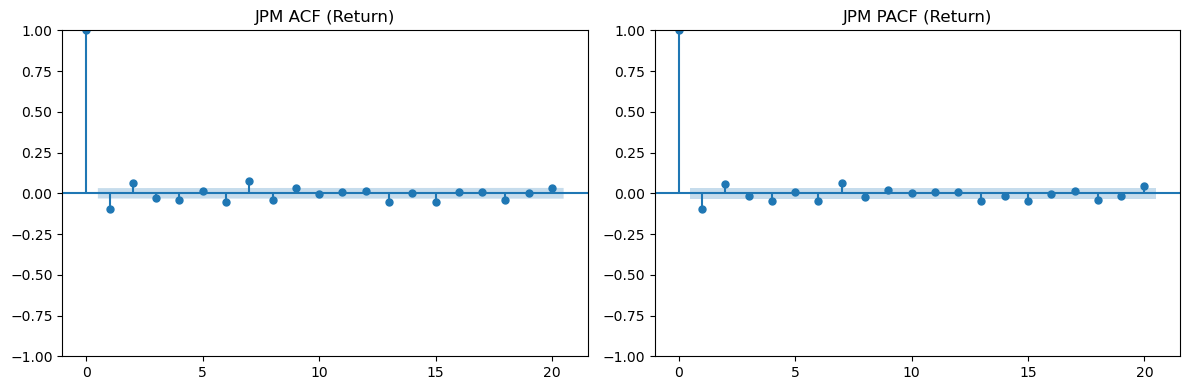


--- V ---
ADF p-value: 0.0000 -> Stationary


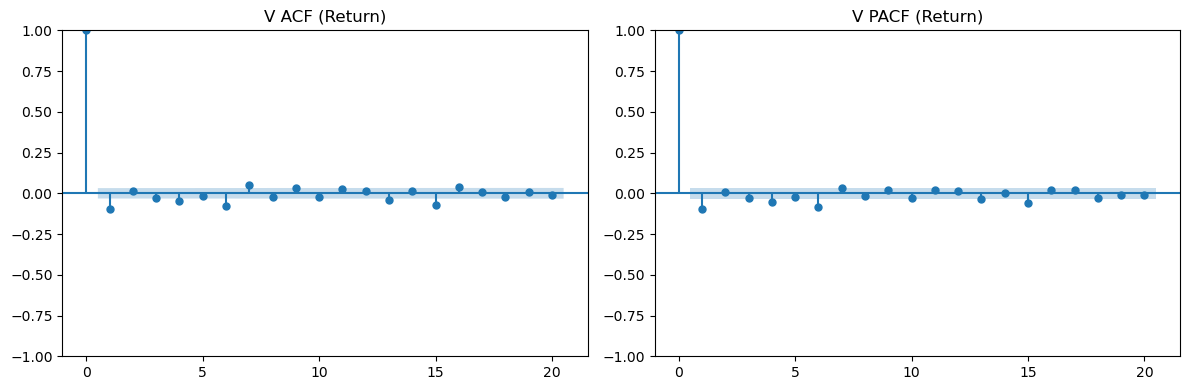


--- MA ---
ADF p-value: 0.0000 -> Stationary


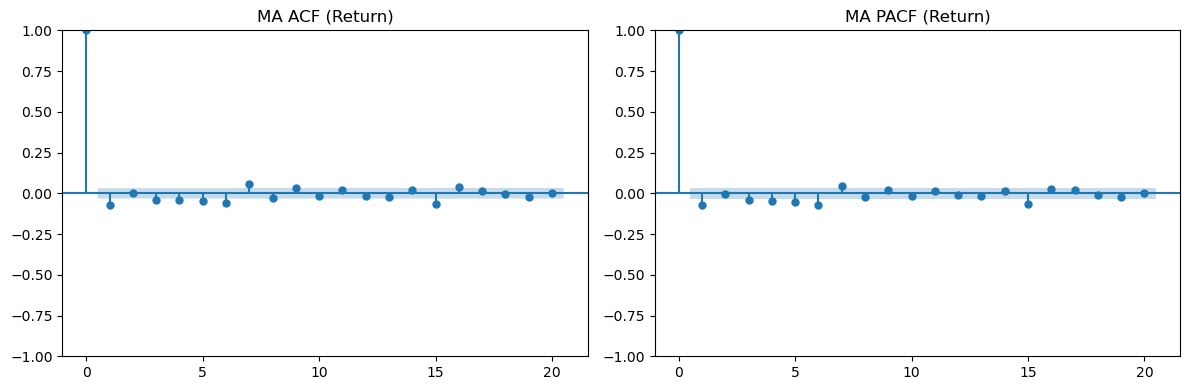

In [68]:
for ticker in financial_df['Ticker'].unique():
    print(f"\n--- {ticker} ---")
    ticker_data = financial_df[financial_df['Ticker'] == ticker]
    returns = ticker_data['Return'].dropna()

    result = adfuller(returns)
    print(f"ADF p-value: {result[1]:.4f} -> {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(returns, ax=axes[0], lags=20)
    plot_pacf(returns, ax=axes[1], lags=20)
    axes[0].set_title(f'{ticker} ACF (Return)')
    axes[1].set_title(f'{ticker} PACF (Return)')
    plt.tight_layout()
    plt.show()

In [69]:
for ticker in financial_df['Ticker'].unique():
    print(f"\n{ticker} ARMA model selection (based on AIC):")
    ticker_data = financial_df[financial_df['Ticker'] == ticker]
    returns = ticker_data['Return'].dropna()

    best_aic = float('inf')
    best_order = None

    for p in range(0, 5):
        for q in range(0, 5):
            try:
                model = ARIMA(returns, order=(p, 0, q))  # ARMA = ARIMA with d=0
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, q)
            except:
                continue

    print(f"Best ARMA order: {best_order} with AIC: {best_aic:.2f}")


JPM ARMA model selection (based on AIC):
Best ARMA order: (3, 3) with AIC: -19881.71

V ARMA model selection (based on AIC):
Best ARMA order: (3, 3) with AIC: -20664.40

MA ARMA model selection (based on AIC):
Best ARMA order: (3, 4) with AIC: -19976.14


In [70]:
def forecast_last_30days_ARMA_1(df, ticker, order):
    print(f"\nForecasting last 30 days for {ticker} using ARMA{order}...")

    # Filter ticker-specific data
    data = df[df['Ticker'] == ticker].dropna(subset=['Return']).reset_index(drop=True)
    returns = data['Return'].values
    dates = data['Date'].values

    # Train-test split (last 30 days as test)
    train, test = returns[:-30], returns[-30:]
    test_dates = dates[-30:]

    # Fit ARMA model
    model = ARIMA(train, order=(order[0], 0, order[1]))
    model_fit = model.fit()

    # Forecast next 30 steps
    forecast = model_fit.forecast(steps=30)

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    # Print metrics
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")

    # Plot actual vs predicted returns
    plt.figure(figsize=(10, 4))
    plt.plot(test_dates, test, label='Actual Returns', color='blue', marker='o')
    plt.plot(test_dates, forecast, label='Predicted Returns', color='red', linestyle='--', marker='x')
    plt.title(f'{ticker}: Actual vs Forecasted Returns (Last 30 Days)\nMAE={mae:.5f}, RMSE={rmse:.5f}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae, rmse


Forecasting last 30 days for JPM using ARMA(3, 3)...
MAE:  0.008760
RMSE: 0.011124


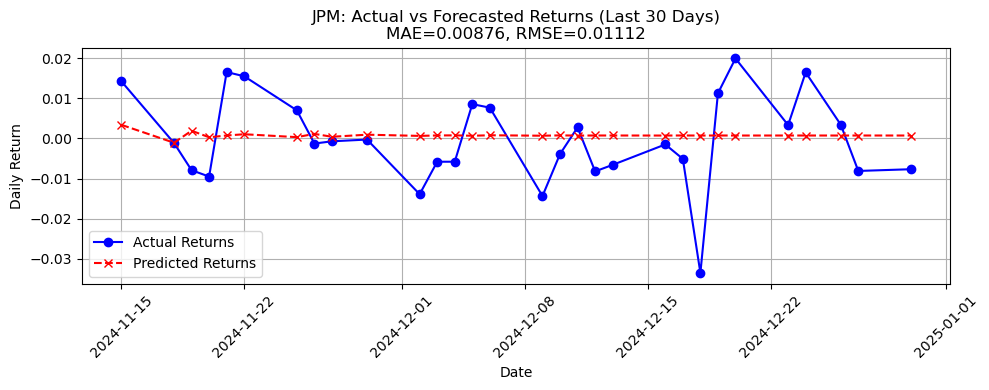


Forecasting last 30 days for V using ARMA(3, 3)...
MAE:  0.007317
RMSE: 0.009325


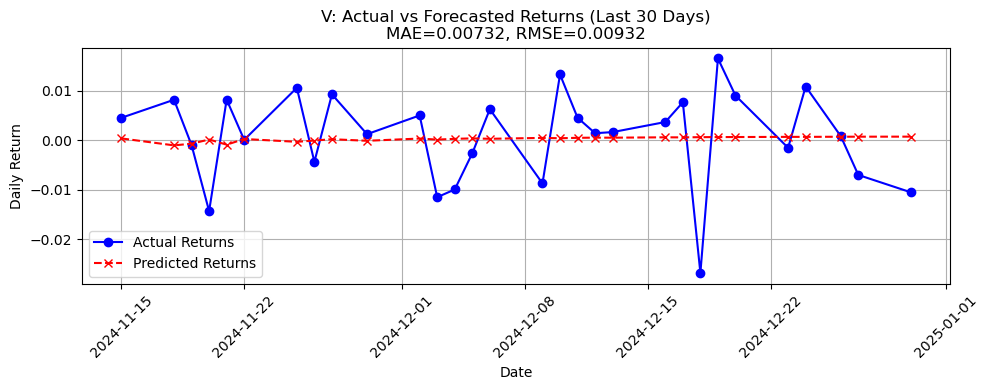


Forecasting last 30 days for MA using ARMA(3, 4)...
MAE:  0.007048
RMSE: 0.008622


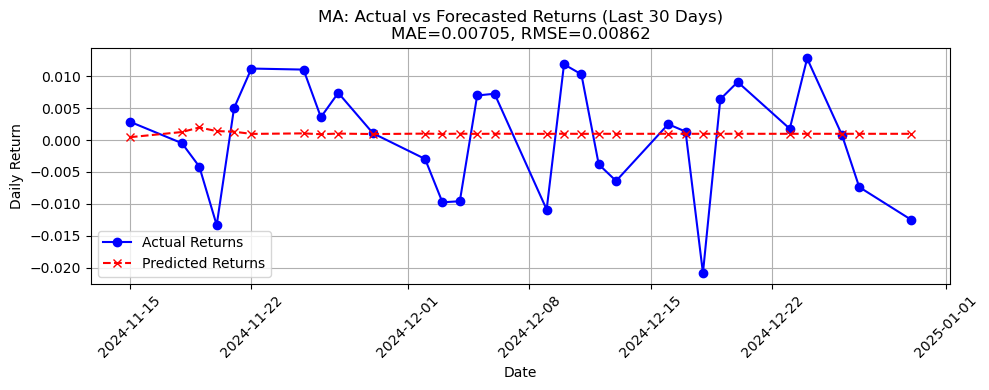

In [72]:
results = {}

results['JPM'] = forecast_last_30days_ARMA_1(financial_df, 'JPM', (3, 3))
results['V'] = forecast_last_30days_ARMA_1(financial_df, 'V', (3, 3))
results['MA'] = forecast_last_30days_ARMA_1(financial_df, 'MA', (3, 4))